# Fit Data to a mixutre of Gaussian distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline  
print ("Packages loaded.")

Packages loaded.


### Define class

In [2]:
tfd = tf.contrib.distributions
class MoG_class(object):
    def __init__(self,_x_dim=2,_k=5,_sess=None):
        self.x_dim = _x_dim 
        self.k = _k # number of mixture
        self.sess = _sess
        self._build_graph()
        # Initialize parameters 
        self.sess.run(tf.global_variables_initializer())
    def _build_graph(self):
        # Placeholder
        self.x = tf.placeholder(dtype=tf.float32,shape=(None,self.x_dim),
                                name='x') # [N x x_dim]
        self.n = tf.shape(self.x)[0] # number of batch
        # Define pi, mu ,and variance
        pi_speed = 100
        pi_initializer = tf.truncated_normal_initializer(stddev=0.1)
        self.pi_mtx = tf.get_variable(name='pi_mtx',shape=(pi_speed,self.k),
                        dtype=tf.float32,initializer=pi_initializer)
        self.pi = tf.reduce_sum(self.pi_mtx,axis=0,name='pi') # [k]
        self.pi = tf.nn.softmax(self.pi) # [k] sum to one
        mu_speed = 100
        mu_initializer = tf.truncated_normal_initializer(stddev=0.1)
        self.mu_mtx = tf.get_variable(name='mu_mtx',shape=(mu_speed,self.x_dim,self.k),
                        dtype=tf.float32,initializer=mu_initializer)
        self.mu = tf.reduce_sum(self.mu_mtx,axis=0,name='mu') # [x_dim x k]
        logvar_speed = 100
        logvar_initializer = tf.truncated_normal_initializer(stddev=0.1)
        self.logvar_mtx = tf.get_variable(name='logvar_mtx',
                            shape=(logvar_speed,self.x_dim,self.k),
                            dtype=tf.float32,initializer=logvar_initializer) # [N x x_dim]
        self.logvar = tf.reduce_sum(self.logvar_mtx,axis=0,name='logvar') # [x_dim x k]
        
        # Sampler 
        self.n_sample = tf.placeholder(dtype=tf.int32,name='N_sample')
        cat = tfd.Categorical(probs=self.pi)
        components = [tfd.MultivariateNormalDiag(loc=self.mu[:,i],
                          scale_diag=tf.exp(self.logvar[:,i])) 
                              for i in range(self.k)]
        self.tfd_mog = tfd.Mixture(cat=cat,components=components)
        self.x_sample = self.tfd_mog.sample(self.n_sample)
        
        # Log likelihood
        self.log_liks = self.tfd_mog.log_prob(self.x)
        self.log_lik = tf.reduce_mean(self.log_liks)
        self.cost = -self.log_lik
        
        # Optimizer
        self.optm = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(self.cost)
        
    def plot_samples(self,_n_sample=1000,_x_others=None,_title_str=None):
        x_sample = self.sess.run(self.x_sample,feed_dict={self.n_sample:_n_sample})
        plt.figure(figsize=(8,6));plt.grid(True)
        if _x_others is not None:
            plt.plot(_x_others[:,0],_x_others[:,1],'r.')
        plt.plot(x_sample[:,0],x_sample[:,1],'bx') 
        if _title_str is not None:
            plt.title(_title_str,fontsize=15)
        plt.axis('equal'); plt.show()

### Train

MoG class instantiated.


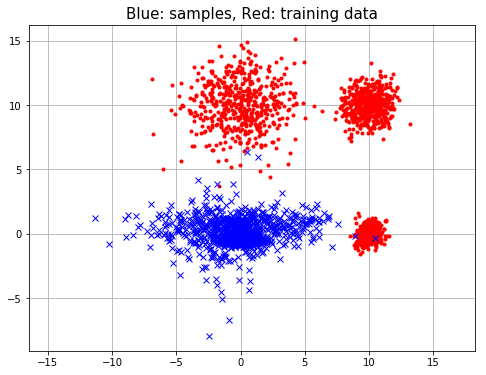

[000/5000] cost:16.7228


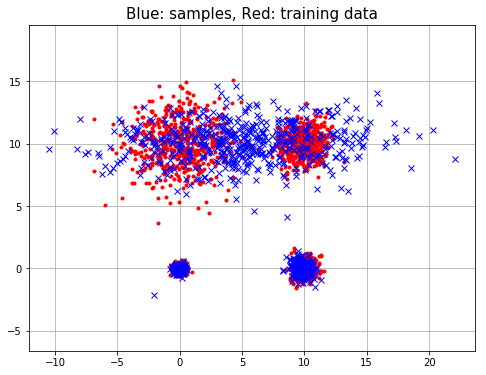

[500/5000] cost:3.6725


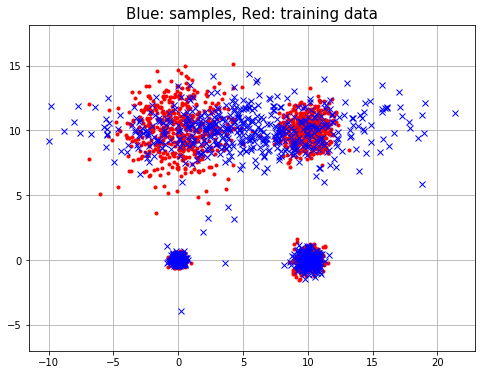

[1000/5000] cost:3.9870


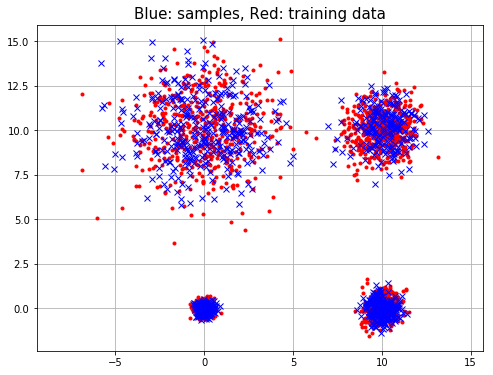

[1500/5000] cost:3.3574


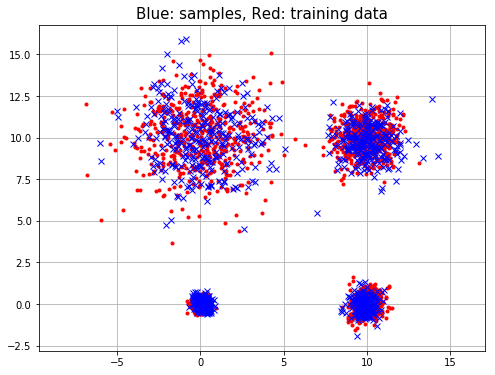

[2000/5000] cost:3.4896


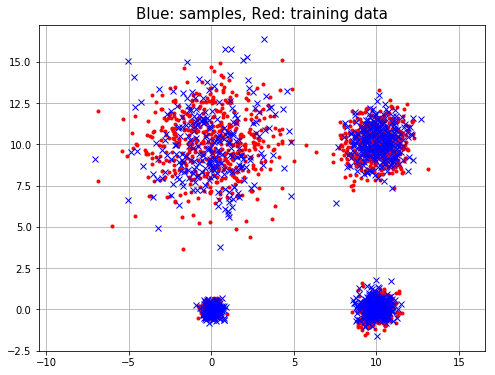

[2500/5000] cost:3.3542


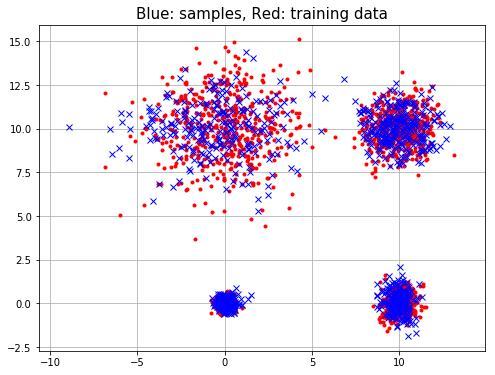

[3000/5000] cost:3.7179


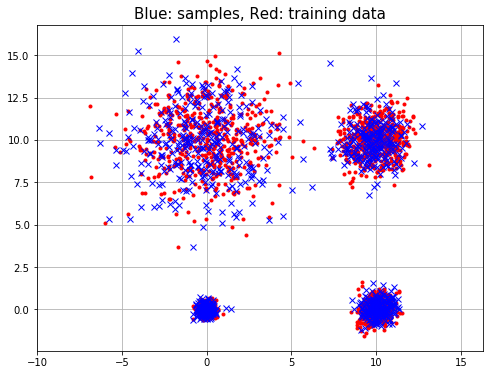

[3500/5000] cost:3.7386


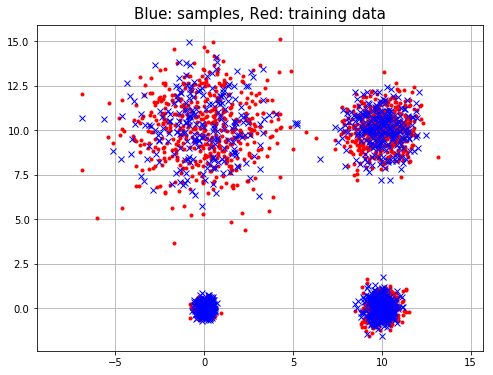

[4000/5000] cost:3.4821


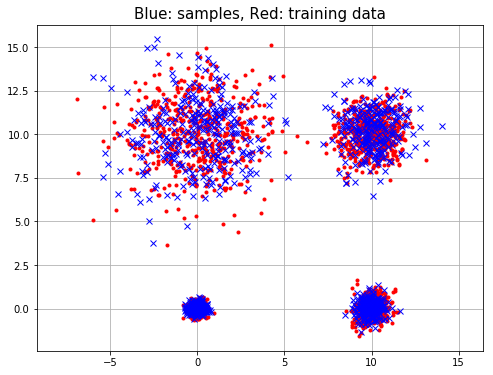

[4500/5000] cost:3.5445


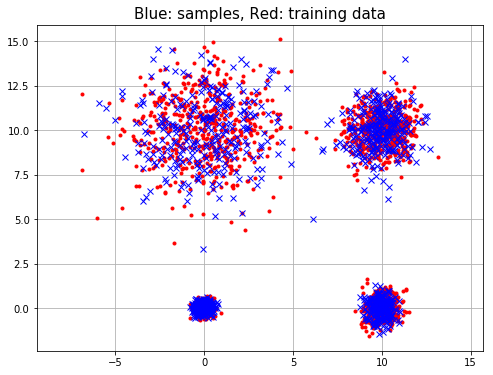

[4999/5000] cost:3.5369


In [3]:
# Instantiate MoG class
tf.reset_default_graph() # Reset graph
sess = tf.Session()
M = MoG_class(_x_dim=2,_k=5,_sess=sess)
print ("MoG class instantiated.")
# Training data
mu1,mu2,mu3,mu4 = np.array([10,0]),np.array([10,10]),np.array([0,10]),np.array([0,0])
var1,var2,var3,var4 = 1/4,1,4,1/16
n1,n2,n3,n4 = 500,500,500,500
x_train = np.concatenate((mu1+np.sqrt(var1)*np.random.randn(n1,2),
                          mu2+np.sqrt(var2)*np.random.randn(n2,2),
                          mu3+np.sqrt(var3)*np.random.randn(n3,2),
                          mu4+np.sqrt(var4)*np.random.randn(n4,2)))
n_train = x_train.shape[0]
# Train 
max_iter = 5000
for iter in range(max_iter):
    x_batch = x_train[np.random.permutation(n_train)[:128],:] # current batch
    _,cost_val = M.sess.run([M.optm,M.cost],feed_dict={M.x:x_batch})
    # Debug 
    if ((iter%(max_iter//10))==0) | (iter==(max_iter-1)):
        M.plot_samples(_n_sample=1000,_x_others=x_train,
                       _title_str='Blue: samples, Red: training data')
        print ("[%03d/%d] cost:%.4f"%(iter,max_iter,cost_val))